# ART calculations for `Marburg` virus

In [26]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [27]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

### Define directories

In [28]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/Marburg_bestMACAW/'
os.makedirs(artResultDir, exist_ok=True)
saveDir = os.path.join(resultsDir, "Marburg/")
#saveDir = os.path.join(resultsDir, "Marburg_bestMACAW/")
os.makedirs(saveDir, exist_ok=True)

### Extract the data for `Marburg` into a data frame with `duplicate` SMILES

In [6]:
MarburgVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "MarburgVirusData_chEMBL_wMACAW.csv")
MarburgVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,...,MACAW_36,MACAW_37,MACAW_38,MACAW_39,MACAW_40,MACAW_41,MACAW_42,MACAW_43,MACAW_44,MACAW_45
0,1,CHEMBL5593581,CN(C)C1CCN(C(=O)c2cc3ccccc3n2Cc2cccnc2)CC1,4.413413,Marburg,-0.122310,0.274089,-0.040032,0.139557,-0.005811,...,-0.074232,0.087697,-0.008297,0.050264,-0.007506,0.093003,-0.007375,0.079435,-0.045863,0.002037
1,2,CHEMBL5593153,CN(C)C1CCN(C(=O)c2cc3occc3n2Cc2ccc(Cl)cc2)CC1,5.099087,Marburg,-0.137225,0.327071,-0.027621,0.186855,0.045965,...,0.098879,-0.004992,0.007890,-0.014787,0.062270,-0.019189,0.089122,0.026018,-0.049004,0.034543
2,4,CHEMBL5593168,CC(C)N1CCN(C(=O)c2cc3sccc3n2Cc2ccc(Cl)cc2)CC1,4.484126,Marburg,-0.119712,0.273791,-0.030392,0.157136,0.033473,...,-0.006600,0.048906,0.082594,0.002345,0.014015,-0.038030,-0.012761,0.048388,0.021040,0.049789
3,5,CHEMBL1236524,Nc1ncnc2c([C@@H]3N[C@H](CO)[C@@H](O)[C@H]3O)c[...,5.522879,Marburg,0.009413,0.020522,0.035893,-0.354140,0.070985,...,-0.039918,-0.138693,-0.020510,0.156257,0.069440,-0.129893,0.103332,0.066651,0.170467,0.108382
4,6,CHEMBL5592994,CCN1CCN(CC(=O)O[C@H]2C(C)(C)[C@H]3CC[C@]2(C)C3...,4.521434,Marburg,0.393294,0.006360,-0.073046,-0.014516,0.021267,...,-0.151761,-0.171347,0.020081,0.063721,0.034510,-0.021248,0.194124,-0.025008,-0.077201,-0.060769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,199,CHEMBL5595280,C[C@@H]1[C@H]2C[C@@H](C[C@H]1OC(=O)CN1CCCCC1)C...,3.970616,Marburg,0.379132,-0.022542,-0.018380,-0.017197,-0.105484,...,0.103347,0.018978,-0.028876,0.039520,-0.073510,-0.044251,-0.056632,-0.041459,0.081637,-0.032098
182,200,CHEMBL5592622,C[C@@H]1[C@H]2C[C@@H](C[C@H]1OC(=O)CN1CCN(C)CC...,4.322393,Marburg,0.359035,-0.013220,-0.031952,-0.013236,-0.092083,...,0.131120,0.098397,-0.021723,-0.091912,-0.062935,-0.022182,-0.108691,-0.050118,0.025314,0.003719
183,201,CHEMBL1655,CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1,6.154902,Marburg,-0.164455,-0.044803,-0.091422,-0.094592,-0.399383,...,-0.045892,-0.023448,-0.013110,0.035239,-0.018042,-0.037312,-0.078137,-0.028063,0.069762,-0.035121
184,202,CHEMBL5590446,CC1(C)[C@H]2CC[C@](C)(C2)[C@H]1OC(=O)CCCN1CCCCC1,5.337242,Marburg,0.426381,-0.034964,-0.080330,0.013305,0.032448,...,0.000944,-0.060575,0.002229,0.039632,0.054847,-0.020802,0.068178,0.035360,-0.073230,0.101640


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [7]:
input_var = [col for col in MarburgVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 45
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15', 'MACAW_16', 'MACAW_17', 'MACAW_18', 'MACAW_19', 'MACAW_20', 'MACAW_21', 'MACAW_22', 'MACAW_23', 'MACAW_24', 'MACAW_25', 'MACAW_26', 'MACAW_27', 'MACAW_28', 'MACAW_29', 'MACAW_30', 'MACAW_31', 'MACAW_32', 'MACAW_33', 'MACAW_34', 'MACAW_35', 'MACAW_36', 'MACAW_37', 'MACAW_38', 'MACAW_39', 'MACAW_40', 'MACAW_41', 'MACAW_42', 'MACAW_43', 'MACAW_44', 'MACAW_45']


In [8]:
features = MarburgVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [9]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [10]:
response = MarburgVirusData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [11]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'MarburgVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [12]:
MarburgVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "MarburgVirusData_chEMBL_wMACAW_ARTready.csv")
MarburgVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.122310
1,1,MACAW_1,-0.137225
2,2,MACAW_1,-0.119712
3,3,MACAW_1,0.009413
4,4,MACAW_1,0.393294
...,...,...,...
8551,181,pPotency,3.970616
8552,182,pPotency,4.322393
8553,183,pPotency,6.154902
8554,184,pPotency,5.337242


### Define the ART parameters needed for the prediction

In [14]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 6,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 186 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_regressor
is_

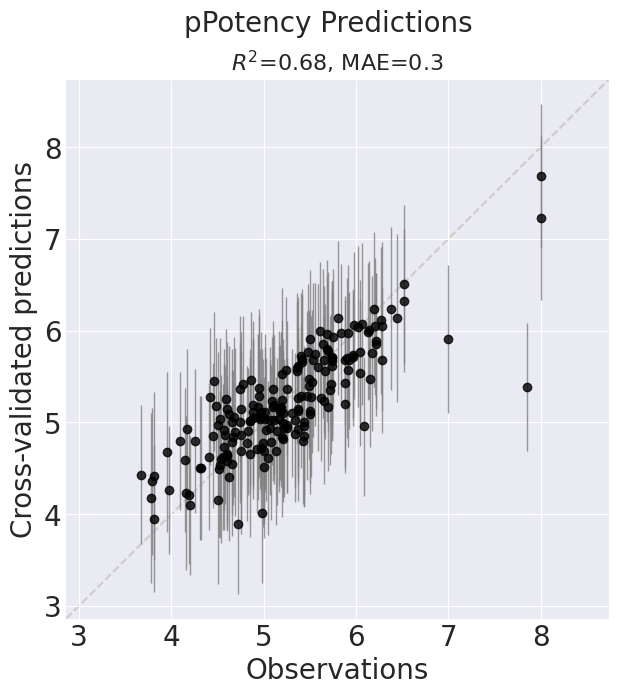

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
i

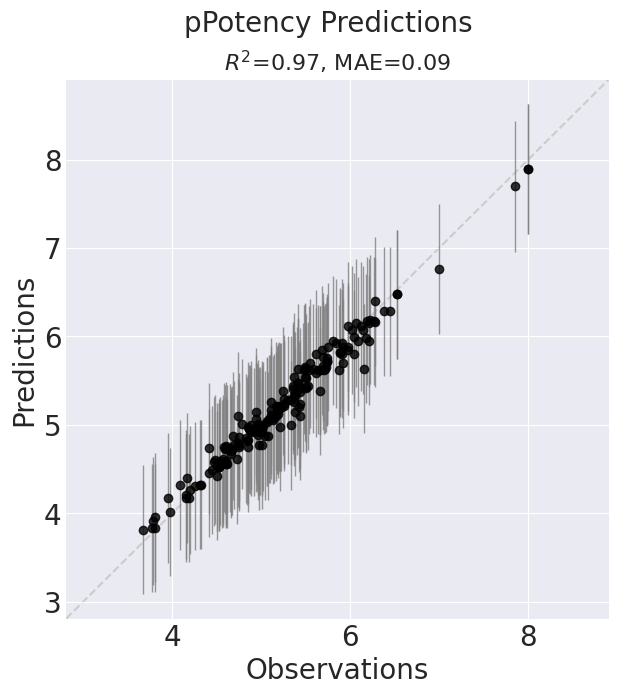

CPU times: user 15min 37s, sys: 9.35 s, total: 15min 46s
Wall time: 2h 8min 4s


In [15]:
%%time

art = RecommendationEngine(df=MarburgVirusData_chEMBL_wMACAW_ARTready, **art_params)

In [17]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [18]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [28]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

 ART model loaded from: /code/DTRA_ART/DrugDesignData/Results/ART_results/Marburg/art.cpkl


### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [1]:
MarburgVirus_EnamineDatasets_wMACAW = pd.read_csv(saveDir + "/Marburg_EnamineDataset_wMACAW.csv")
MarburgVirus_EnamineDatasets_wMACAW

NameError: name 'pd' is not defined

In [ ]:
macaw_columns = [col for col in MarburgVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = MarburgVirus_EnamineDatasets_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = MarburgVirus_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/MarburgVirus_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/MarburgVirus_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
MarburgVirus_LCAntiviralsData_wMACAW = pd.read_csv(saveDir + "/Marburg_LCAntiviralsData_wMACAW.csv")
MarburgVirus_LCAntiviralsData_wMACAW

In [ ]:
macaw_columns = [col for col in MarburgVirus_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = MarburgVirus_LCAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = MarburgVirus_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/MarburgVirus_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/MarburgVirus_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
MarburgVirus_ChemDivAntiviralsData_wMACAW = pd.read_csv(saveDir + "/Marburg_ChemDivAntiviralsData_wMACAW.csv")
MarburgVirus_ChemDivAntiviralsData_wMACAW

In [ ]:
macaw_columns = [col for col in MarburgVirus_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = MarburgVirus_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = MarburgVirus_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/MarburgVirus_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/MarburgVirus_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [ ]:
MarburgVirus_SMACCAntiviralsData_wMACAW = pd.read_csv(saveDir + "/Marburg_SMACCAntiviralsData_wMACAW.csv")
MarburgVirus_SMACCAntiviralsData_wMACAW

In [ ]:
macaw_columns = [col for col in MarburgVirus_SMACCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_SMACCAntiviralsData_wMACAW = MarburgVirus_SMACCAntiviralsData_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_SMACCAntiviralsData_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_SMACCAntiviralsData_wMACAW)

# Now use these for your results
SMACCAntiviralsData_predicted = MarburgVirus_SMACCAntiviralsData_wMACAW[['SMILES']].copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(saveDir + "/MarburgVirus_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/MarburgVirus_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
SMACCAntiviralsData_predicted

### 2.5 Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [ ]:
MarburgVirus_DTRA_target_antivirals_wMACAW = pd.read_csv(saveDir + "/Marburg_DTRA_smiles_wMACAW.csv")
MarburgVirus_DTRA_target_antivirals_wMACAW

In [ ]:
macaw_columns = [col for col in MarburgVirus_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = MarburgVirus_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [ ]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = MarburgVirus_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(saveDir + "/MarburgVirus_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(saveDir + "/MarburgVirus_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

# Prepare to run `ART`  without `duplicate` SMILES

In [18]:
MarburgVirusData_chEMBL_noDuplicates_wMACAW = pd.read_csv(modelBuildingDataDir + "MarburgVirusData_chEMBL_noDuplicates_wMACAW.csv")
MarburgVirusData_chEMBL_noDuplicates_wMACAW 

,Smiles,VirusClassifier,pPotency,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,C#CN(CCCC1(C)N=N1)C(=O)[C@]12CCC(C)(C)C[C@H]1C...,Marburg,5.258061,0.096294,0.040081,-0.020653,0.027424,-0.098208,0.212749,-0.035756,0.162738,0.059961,-0.062915,0.122243,-0.127403,0.066208,-0.012460,0.099996
1,C1=C2CCCN(Cc3ccccc3)[C@H]2[C@@H]2C[C@H]1[C@H]1...,Marburg,4.657577,0.020111,0.053989,0.447802,0.001634,0.037832,-0.093335,-0.070373,-0.016661,0.045187,-0.119356,-0.054247,0.035113,-0.043630,0.076878,0.023473
2,C1=C2CCCN[C@H]2[C@@H]2C[C@H]1[C@H]1CCCCN1C2,Marburg,4.991400,0.135951,0.030387,0.221888,0.096208,0.012261,-0.098418,-0.088165,0.018272,-0.033093,-0.049862,-0.087238,-0.023511,-0.115865,-0.047232,0.059802
3,C=C(C)O[C@@H]1[C@@H](OC(C)=O)[C@H](NC(=O)[C@]2...,Marburg,5.640165,0.027566,0.105004,-0.040220,0.040741,-0.092969,0.227915,-0.065115,0.230053,0.023518,-0.052013,0.171743,-0.080571,0.016339,-0.094676,0.136973
4,CC(C)(C)c1ccc(NC(=O)c2ccc(CN3CCCCC3)cc2)c(C(C)...,Marburg,5.698970,-0.098096,0.069197,-0.018665,0.014405,-0.178911,0.066159,0.044314,-0.187857,0.165078,0.064023,0.147057,-0.088691,-0.045974,0.010877,0.029217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,O=[N+]([O-])c1cc(S(=O)(=O)NCCN2CCOCC2)ccc1Sc1n...,Marburg,4.889410,-0.066415,0.122191,-0.064958,0.066884,-0.009291,0.066199,0.026149,0.102802,0.004668,-0.009615,0.026108,0.056977,-0.006718,0.001850,-0.177388
148,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,Marburg,5.193820,-0.015830,0.047297,-0.073773,0.237434,-0.013435,-0.078597,0.144179,0.067829,0.044435,0.105858,-0.022159,0.008587,-0.085792,-0.111479,0.003809
149,OCCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1,Marburg,4.464073,-0.124745,0.108348,-0.034391,0.111389,0.034345,-0.112531,-0.002337,-0.182290,-0.010467,-0.057762,-0.032292,-0.013378,0.129881,-0.059852,-0.088230
150,Oc1ccc2c(Oc3ccc(OCCN4CCCCC4)cc3)c(-c3ccc(F)cc3...,Marburg,5.690370,-0.125370,0.287772,-0.114605,-0.030326,0.113901,-0.280212,0.102361,0.144225,0.133314,0.014082,0.018024,0.009238,0.021276,-0.017612,0.001645


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [19]:
input_var = [col for col in MarburgVirusData_chEMBL_noDuplicates_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [20]:
features = MarburgVirusData_chEMBL_noDuplicates_wMACAW[input_var].to_numpy()

In [21]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [22]:
response = MarburgVirusData_chEMBL_noDuplicates_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [23]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'MarburgVirusData_chEMBL_noDuplicates_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [24]:
MarburgVirusData_chEMBL_noDuplicates_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "MarburgVirusData_chEMBL_noDuplicates_wMACAW_ARTready.csv")
MarburgVirusData_chEMBL_noDuplicates_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,0.096294
1,1,MACAW_1,0.020111
2,2,MACAW_1,0.135951
3,3,MACAW_1,0.027566
4,4,MACAW_1,-0.098096
...,...,...,...
2427,147,pPotency,4.889410
2428,148,pPotency,5.193820
2429,149,pPotency,4.464073
2430,150,pPotency,5.690370


### Define the ART parameters needed for the prediction

In [25]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 6,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

In [ ]:
%%time

art = RecommendationEngine(df=MarburgVirusData_chEMBL_noDuplicates_wMACAW_ARTready, **art_params)